# Approche “Modèle sur mesure avancé”

On va tester plusieurs modèles et choisir le meilleur pour ensuite l'entraîner et le déployer sur Azure Machine Learning

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import time

from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, TextVectorization, Activation
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC
import tensorflow as tf

import spacy
from nltk.stem import PorterStemmer

from gensim.models import word2vec

import src.helpers.data_helpers as dth

### Chargement des données

In [21]:
# Charger les données depuis le fichier csv
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data = data[["text", "target"]]

# On supprime les tweets en doublons
data.drop_duplicates(subset=['text'], inplace=True)

# Remplacer les valeurs par les vrais labels
data['target'] = data['target'].map(
    {
        0: "NEGATIF",
        4: "POSITIF"
    }
)

# Binarize target
data['target'] = data['target'].map(
    {
        "NEGATIF": 0,
        "POSITIF": 1,
    }
)

data.describe()

,target
count,1.581466e+06
mean,5.003465e-01
std,5.000000e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


Comme on travaille en local pour déterminer le meilleur modèle, on va travailler sur un échantillion de 40 000 tweets afin de diminuer les temps de calcul.

Le meilleur modèle sera ré-entraîné sur Azure Machine Learning en utilisant la totalité du jeu de données.

In [22]:
# Echantillon du jeu de données
sample_positif = data[data["target"] == 1].sample(n = 20000)
sample_negatif = data[data["target"] == 0].sample(n = 20000)

sample = pd.concat([sample_negatif, sample_positif])

X = sample['text']
y = sample['target']

### Choix des métriques

Pour déterminer le meilleur modèle on fera une synthèse comparative avec les métriques suivantes :

- f1 score
- accuracy
- Recall
- ROC AUC
- Temps pour l'entraînement

In [23]:
import json

synthese = {}
train_times = {}
if os.path.exists('models/train_times.json'):
    with open('models/train_times.json', 'r') as f:
        train_times = json.load(f)

### Modèle simple avec lemmatisation / stemming et embedding Word2Vec / Glove

On va commencer par un modèle de Deep Learning simple composé d'une couche d'Embedding, une couche LSTM et une couche Dense.

On entraîne le modèle 4 fois en changeant la technique de prétraitement du texte, et la méthode de plongement de mots.

**Prétraitement du texte :**

- Lemmatisation
- Stemming

**Plongement de mots :**

- Word2Vec
- Glove



In [24]:
nlp = spacy.load('en_core_web_sm')

all_stopwords = nlp.Defaults.stop_words

# Ajout / Suppression de stop words
all_stopwords.add('re')
if 'not' in all_stopwords:
    all_stopwords.remove('not')

In [25]:
# Prétraitement du texte aveec lemmatization et suppression des stops words, des caractères spéciaux et passage en minuscule
X_lemma = [[token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [26]:
ps = PorterStemmer()

# Prétraitement du texte aveec stemming et suppression des stops words, des caractères spéciaux et passage en minuscule
X_stemm = [[ps.stem(token.text) for token in doc if token.is_alpha and token.text.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [27]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
X_train_stemm, X_test_stemm, y_train_stemm, y_test_stemm = train_test_split(X_stemm, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
# Dictionnaire pour le plongement de mots avec Glove
emmbed_dict = {}
with open('data/glove.twitter.27B.200d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        emmbed_dict[word] = vector

print(f'Il y a {len(emmbed_dict)} mots vectorisés')

Il y a 1193514 mots vectorisés


In [30]:
# Retourne l'embedding avec Word2Vec
def createEmbeddingLayerWord2Vec(tokenizer, X_train):
    w2v_model = word2vec.Word2Vec(vector_size=300, min_count=5)

    w2v_model.build_vocab(X_train)

    w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=32)

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 300))

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)

    return Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

# Retourne l'embedding avec Glove
def createEmbeddingLayerGlove(tokenizer, emmbed_dict):

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 200))

    for word, i in tokenizer.word_index.items():
        embedding_vector = emmbed_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)

In [31]:
# Tokenizer avec lemmatization
tokenizer_lemma = Tokenizer()
tokenizer_lemma.fit_on_texts(X_train_lemma)

# Tokenizer avec stemming
tokenizer_stemm = Tokenizer()
tokenizer_stemm.fit_on_texts(X_train_stemm)

def tokenize_data(data,tokenizer,maxlen=None):
    X = tokenizer.texts_to_sequences(data)
    return pad_sequences(X,maxlen=maxlen)

In [32]:
# Modèle de deep learning simple
def trainModel(model_name, embedding_layer, X_train, y_train, X_test, y_test, embedding_dim, tokenizer):

    x_train = tokenize_data(X_train,tokenizer,maxlen=embedding_dim)
    x_test = tokenize_data(X_test,tokenizer,maxlen=embedding_dim)

    model_path = os.path.join('models', model_name)

    if os.path.exists(model_path):
        model = load_model(model_path)
        training_time = train_times[model_name]

    else:
        start_train = time.time()
        # Create LSTM Model
        model = Sequential(name=model_name)
        model.add(embedding_layer)
        model.add(LSTM(256))

        # Classification layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile
        model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

        print(model.summary())

        # Train
        model.fit(
            x_train,
            y_train,
            validation_split=0.2,
            epochs = 4,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,)

        # Save the model
        model.save(model_path)

        end_train = time.time()
        training_time = end_train - start_train
        train_times[model_name] = training_time

    start_pred = time.time()

    y_test_pred_proba = model.predict(
        x_test,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

    y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

    end_pred= time.time()
    predict_time = end_pred - start_pred

    synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

    print(f"Resultats modèle : {model_name}")

    dth.plot_classifier_results(model, x_test, y_test, y_test_pred, y_test_pred_proba)

Entraînement des 4 modèles

Model: "stemm_word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          6034800   
                                                                 
 lstm (LSTM)                 (None, 256)               570368    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 6,605,425
Trainable params: 570,625
Non-trainable params: 6,034,800
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 765s 955ms/step - loss: 0.5679 - auc: 0.7780 - accuracy: 0.7087 - val_loss: 0.5482 - val_auc: 0.7984 - val_accuracy: 0.7113
Epoch 2/4
800/800 [==============================] - 782s 977ms/step - loss: 0.5318 - auc: 0.8089 - accuracy: 0.7

INFO:tensorflow:Assets written to: models\stemm_word2vec_lstm\assets


INFO:tensorflow:Assets written to: models\stemm_word2vec_lstm\assets


Resultats modèle : stemm_word2vec_lstm


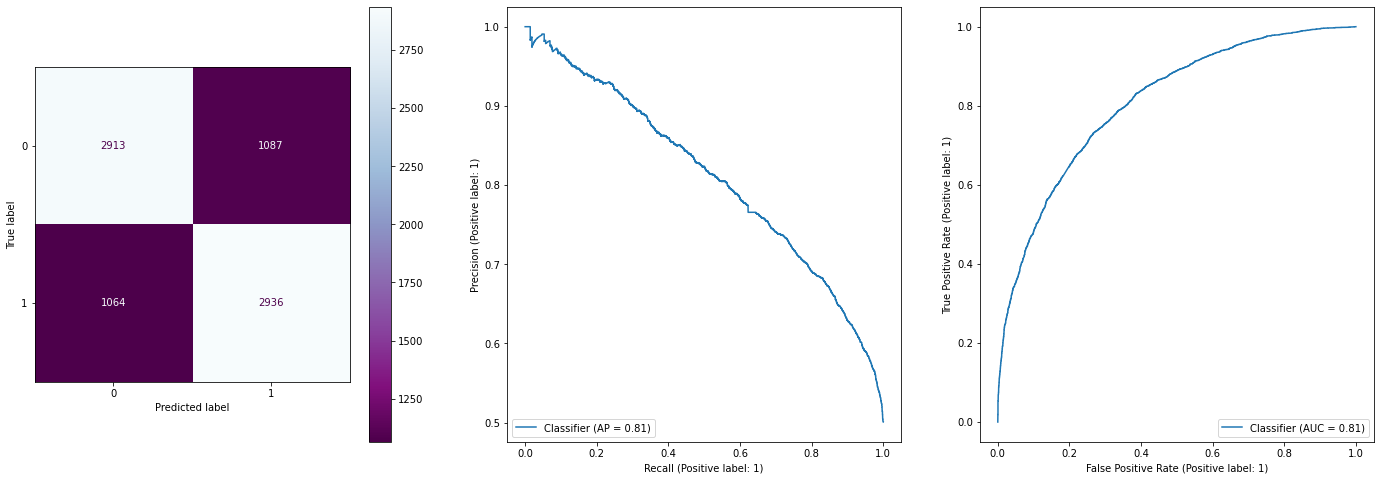

Model: "lemma_word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          6718800   
                                                                 
 lstm_1 (LSTM)               (None, 256)               570368    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 7,289,425
Trainable params: 570,625
Non-trainable params: 6,718,800
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 745s 930ms/step - loss: 0.5702 - auc: 0.7762 - accuracy: 0.7050 - val_loss: 0.5442 - val_auc: 0.7979 - val_accuracy: 0.7191
Epoch 2/4
800/800 [==============================] - 784s 981ms/step - loss: 0.5369 - auc: 0.8036 - accuracy: 0.7

INFO:tensorflow:Assets written to: models\lemma_word2vec_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_word2vec_lstm\assets


Resultats modèle : lemma_word2vec_lstm


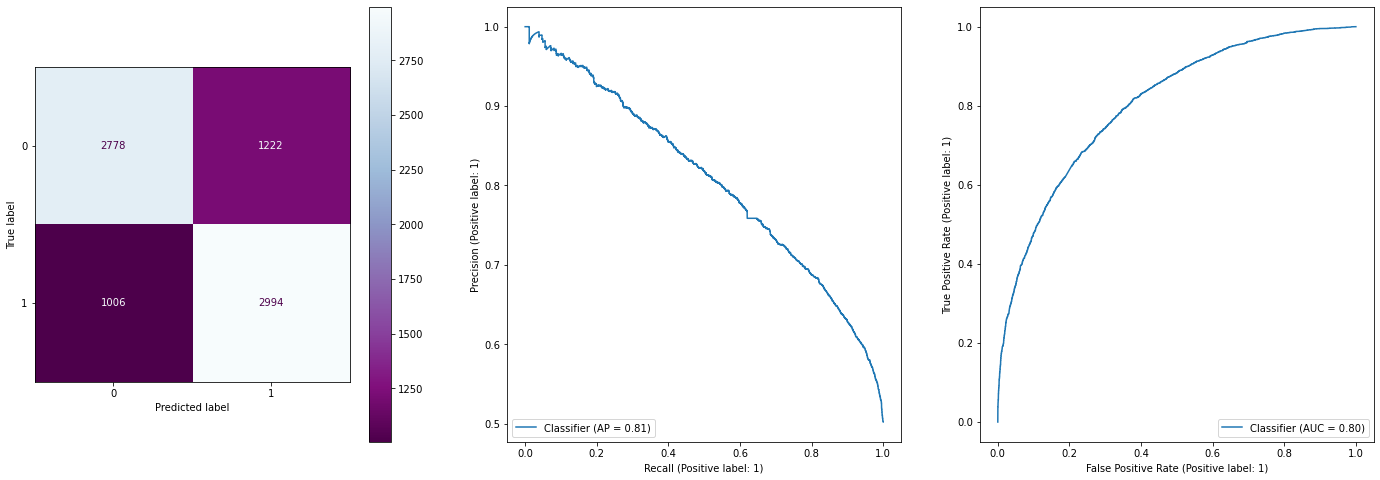

Model: "stemm_glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          4023200   
                                                                 
 lstm_2 (LSTM)               (None, 256)               467968    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,491,425
Trainable params: 468,225
Non-trainable params: 4,023,200
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 383s 478ms/step - loss: 0.5449 - auc: 0.7981 - accuracy: 0.7224 - val_loss: 0.5328 - val_auc: 0.8221 - val_accuracy: 0.7252
Epoch 2/4
800/800 [==============================] - 378s 473ms/step - loss: 0.4993 - auc: 0.8353 - accuracy: 0.7523

INFO:tensorflow:Assets written to: models\stemm_glove_lstm\assets


INFO:tensorflow:Assets written to: models\stemm_glove_lstm\assets


Resultats modèle : stemm_glove_lstm


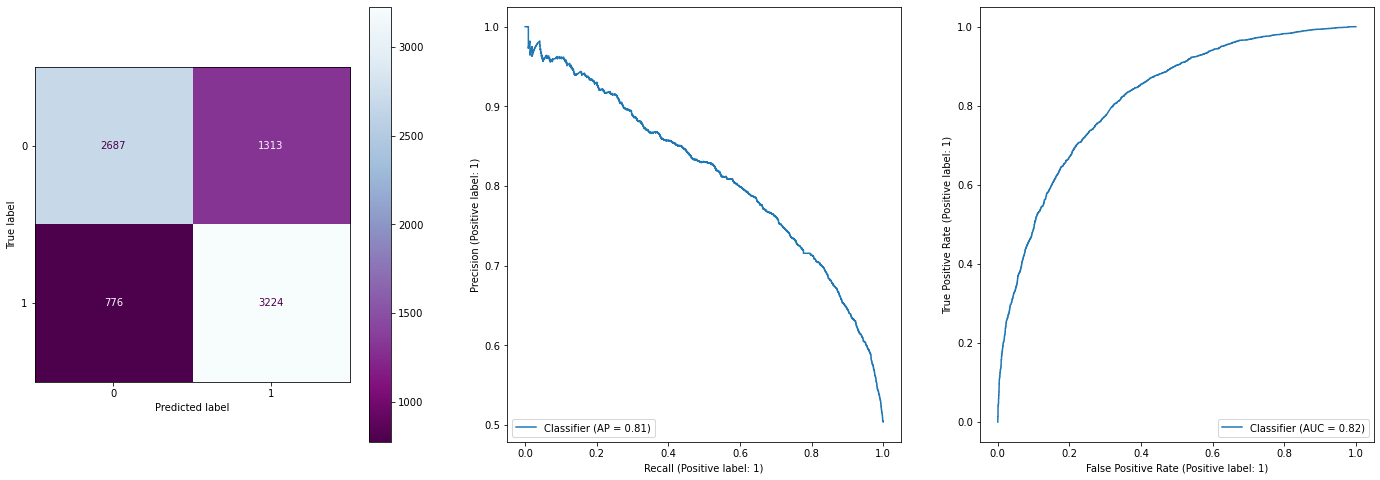

Model: "lemma_glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 200)          4479200   
                                                                 
 lstm_3 (LSTM)               (None, 256)               467968    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 4,947,425
Trainable params: 468,225
Non-trainable params: 4,479,200
_________________________________________________________________
None
Epoch 1/4
800/800 [==============================] - 379s 472ms/step - loss: 0.5275 - auc: 0.8135 - accuracy: 0.7400 - val_loss: 0.5003 - val_auc: 0.8384 - val_accuracy: 0.7516
Epoch 2/4
800/800 [==============================] - 379s 473ms/step - loss: 0.5311 - auc: 0.8104 - accuracy: 0.7336

INFO:tensorflow:Assets written to: models\lemma_glove_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_glove_lstm\assets


Resultats modèle : lemma_glove_lstm


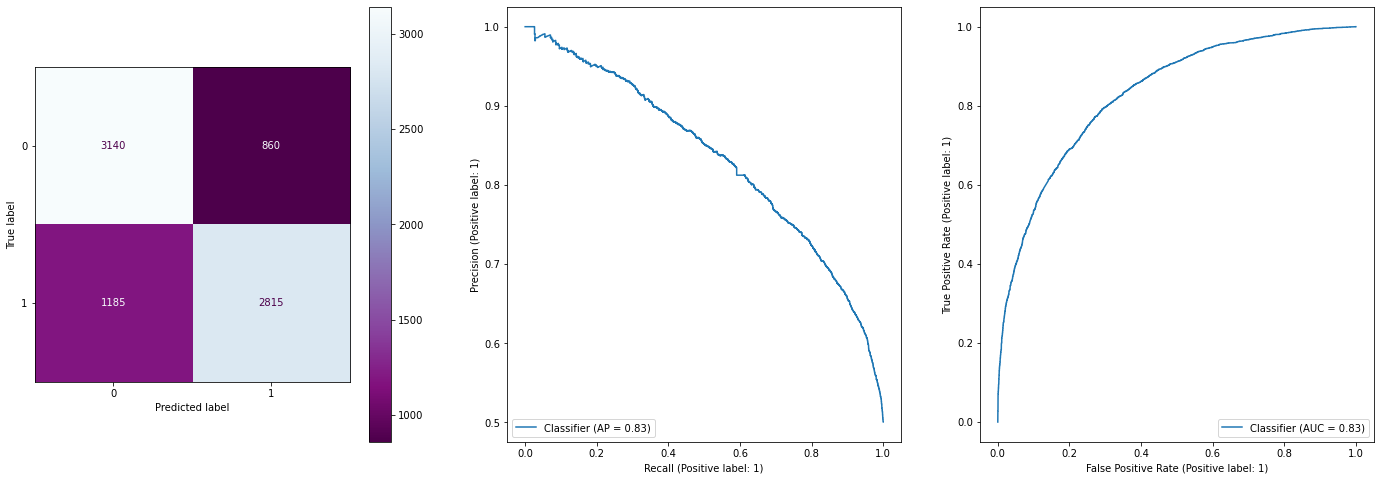

In [33]:
trainModel('stemm_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_stemm, X_train_stemm), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 300, tokenizer_stemm)

trainModel('lemma_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_lemma, X_train_lemma), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 300, tokenizer_lemma)

trainModel('stemm_glove_lstm', createEmbeddingLayerGlove(tokenizer_stemm, emmbed_dict), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 200, tokenizer_stemm)

trainModel('lemma_glove_lstm', createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 200, tokenizer_lemma)

### Modèle Feed-Forward Neural Network

Avec un simple vecteur comptant les mots en entrée, sans prétraitement de texte

In [34]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [35]:
model_name = "ffnn_on_count"
vocabulary_size = 10000

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # Define vectorizer
    vectorize_layer = TextVectorization(
            output_mode="count",
            max_tokens=vocabulary_size,
            pad_to_max_tokens=True,
        )
    vectorize_layer.adapt(
            X,
            batch_size=128,
        )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Dense(100, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                "accuracy",
                AUC(curve="ROC", name="ROC_AUC"),
                AUC(curve="PR", name="AP"),
            ],
        )

    # fit NN model
    model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )

    # Save the model
    model.save(model_path)
    
    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

Epoch 1/10
200/200 [==============================] - 5s 23ms/step - loss: 0.5711 - accuracy: 0.7072 - ROC_AUC: 0.7842 - AP: 0.7678 - val_loss: 0.4949 - val_accuracy: 0.7725 - val_ROC_AUC: 0.8461 - val_AP: 0.8398
Epoch 2/10
200/200 [==============================] - 4s 21ms/step - loss: 0.4317 - accuracy: 0.8064 - ROC_AUC: 0.8846 - AP: 0.8782 - val_loss: 0.4909 - val_accuracy: 0.7689 - val_ROC_AUC: 0.8501 - val_AP: 0.8443
Epoch 3/10
200/200 [==============================] - 4s 21ms/step - loss: 0.3415 - accuracy: 0.8551 - ROC_AUC: 0.9302 - AP: 0.9290 - val_loss: 0.5125 - val_accuracy: 0.7648 - val_ROC_AUC: 0.8452 - val_AP: 0.8424
Epoch 4/10
200/200 [==============================] - 4s 21ms/step - loss: 0.2508 - accuracy: 0.9002 - ROC_AUC: 0.9641 - AP: 0.9637 - val_loss: 0.5860 - val_accuracy: 0.7613 - val_ROC_AUC: 0.8383 - val_AP: 0.8357
INFO:tensorflow:Assets written to: models\ffnn_on_count\assets


INFO:tensorflow:Assets written to: models\ffnn_on_count\assets


In [36]:
start_pred = time.time()

y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred = time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

Resultats modèle : ffnn_on_count


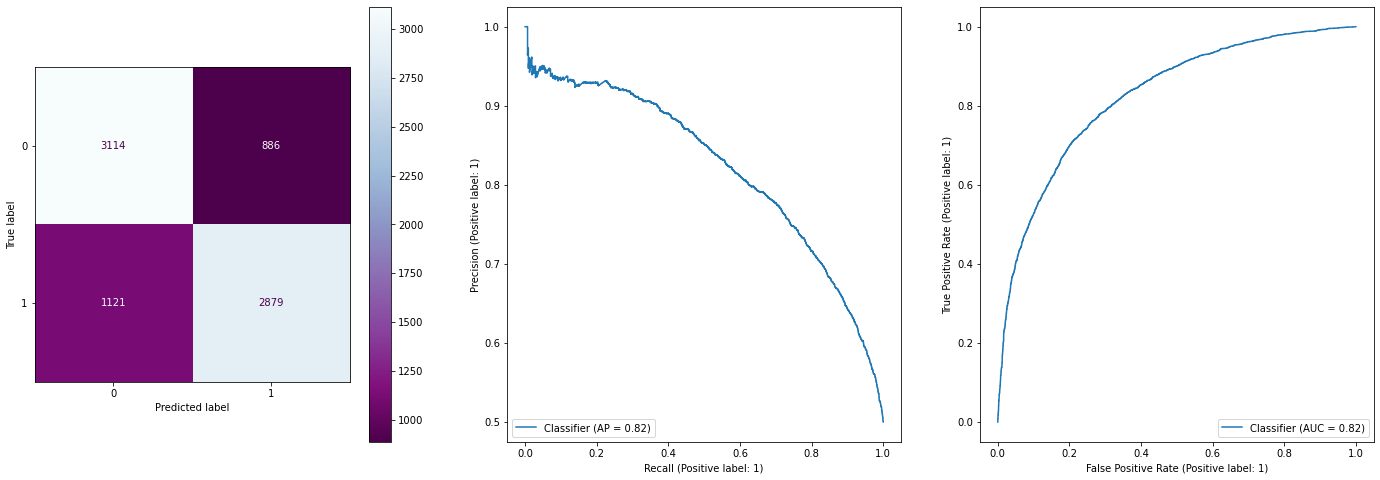

In [37]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

## Modèle bidirectional LSTM (embedding automatique)

Chaque mot est converti en nombre, et l'embedding est automatique sur la couche Embedding

In [38]:
model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # Define vectorizer
    vectorize_layer = TextVectorization(
            output_mode="int",
            max_tokens=max_features,
            output_sequence_length=sequence_length,
        )
    vectorize_layer.adapt(
            X,
            batch_size=128,
        )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
            Embedding(
                max_features,
                embedding_dim,
                input_length=sequence_length,
            )
        )

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(100, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                "accuracy",
                AUC(curve="ROC", name="ROC_AUC"),
                AUC(curve="PR", name="AP"),
            ],
        )

    # fit NN model
    model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )

    # Save the model
    model.save(model_path)

    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time   

Epoch 1/10
200/200 [==============================] - 27s 118ms/step - loss: 0.5653 - accuracy: 0.6960 - ROC_AUC: 0.7760 - AP: 0.7759 - val_loss: 0.4804 - val_accuracy: 0.7727 - val_ROC_AUC: 0.8528 - val_AP: 0.8591
Epoch 2/10
200/200 [==============================] - 22s 109ms/step - loss: 0.4299 - accuracy: 0.8081 - ROC_AUC: 0.8837 - AP: 0.8822 - val_loss: 0.4741 - val_accuracy: 0.7723 - val_ROC_AUC: 0.8539 - val_AP: 0.8578
Epoch 3/10
200/200 [==============================] - 23s 113ms/step - loss: 0.3713 - accuracy: 0.8404 - ROC_AUC: 0.9146 - AP: 0.9147 - val_loss: 0.4954 - val_accuracy: 0.7658 - val_ROC_AUC: 0.8490 - val_AP: 0.8522
Epoch 4/10
200/200 [==============================] - 25s 128ms/step - loss: 0.3182 - accuracy: 0.8688 - ROC_AUC: 0.9377 - AP: 0.9389 - val_loss: 0.5638 - val_accuracy: 0.7613 - val_ROC_AUC: 0.8367 - val_AP: 0.8341


INFO:tensorflow:Assets written to: models\bidirectional_lstm\assets


INFO:tensorflow:Assets written to: models\bidirectional_lstm\assets


In [39]:
start_pred = time.time()

y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred= time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

Resultats modèle : bidirectional_lstm


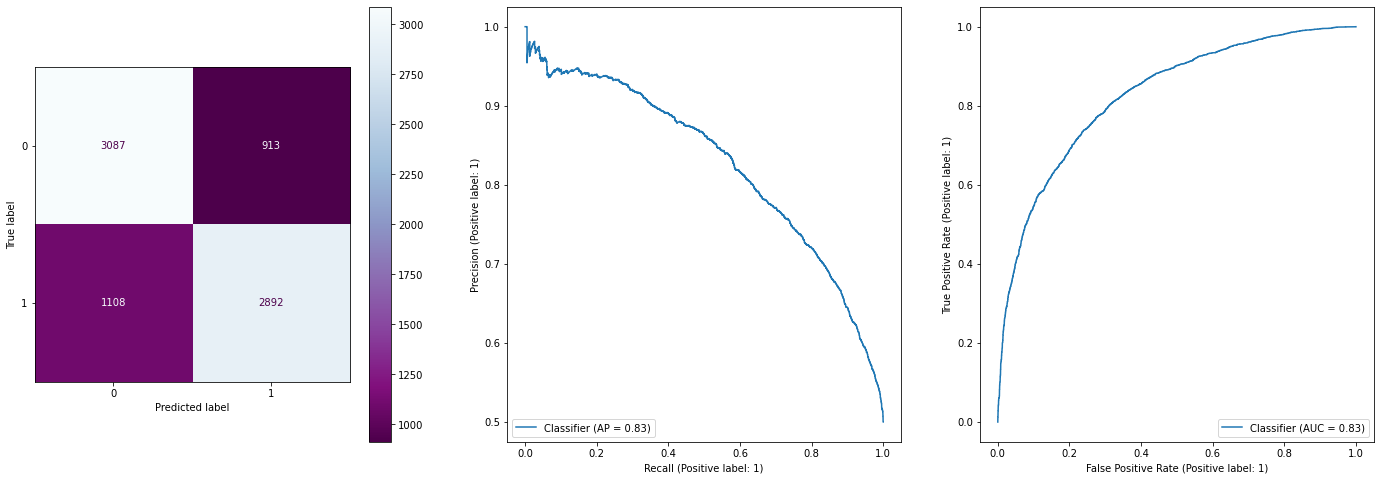

In [40]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

## Modèle bidirectionnal LSTM (Embedding personnalisé)

- C'est fois ci sur la couche d'Embedding on utilise le meilleur plongement de mots déterminé précédemment: **Glove**.
- Un prétaitement de texte est appliqué sur les tweets avec la **Lemmatisation**

In [41]:
embedding_layer = createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict)

x_train_lemma = tokenize_data(X_train_lemma, tokenizer_lemma, maxlen=200)
x_test_lemma = tokenize_data(X_test_lemma, tokenizer_lemma, maxlen=200)

model_name = "lemma_glove_bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # define NN model
    model = Sequential(name=model_name)
    model.add(embedding_layer)

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(100, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

    # fit NN model
    model.fit(
            x_train_lemma,
            y_train_lemma,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )
    
    # Save the model
    model.save(model_path)

    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

Epoch 1/10
200/200 [==============================] - 194s 957ms/step - loss: 0.5585 - auc: 0.7847 - accuracy: 0.7108 - val_loss: 0.5055 - val_auc: 0.8311 - val_accuracy: 0.7462
Epoch 2/10
200/200 [==============================] - 187s 933ms/step - loss: 0.5153 - auc: 0.8231 - accuracy: 0.7441 - val_loss: 0.4982 - val_auc: 0.8380 - val_accuracy: 0.7494
Epoch 3/10
200/200 [==============================] - 197s 985ms/step - loss: 0.5005 - auc: 0.8351 - accuracy: 0.7570 - val_loss: 0.4979 - val_auc: 0.8415 - val_accuracy: 0.7509
Epoch 4/10
200/200 [==============================] - 199s 997ms/step - loss: 0.4870 - auc: 0.8451 - accuracy: 0.7659 - val_loss: 0.4894 - val_auc: 0.8438 - val_accuracy: 0.7619
Epoch 5/10
200/200 [==============================] - 200s 1s/step - loss: 0.4724 - auc: 0.8552 - accuracy: 0.7760 - val_loss: 0.4911 - val_auc: 0.8440 - val_accuracy: 0.7539
Epoch 6/10
200/200 [==============================] - 201s 1s/step - loss: 0.4586 - auc: 0.8646 - accuracy: 0.781

INFO:tensorflow:Assets written to: models\lemma_glove_bidirectional_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_glove_bidirectional_lstm\assets


In [42]:
start_pred = time.time()

y_test_pred_proba = model.predict(
        x_test_lemma,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred= time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

Resultats modèle : lemma_glove_bidirectional_lstm


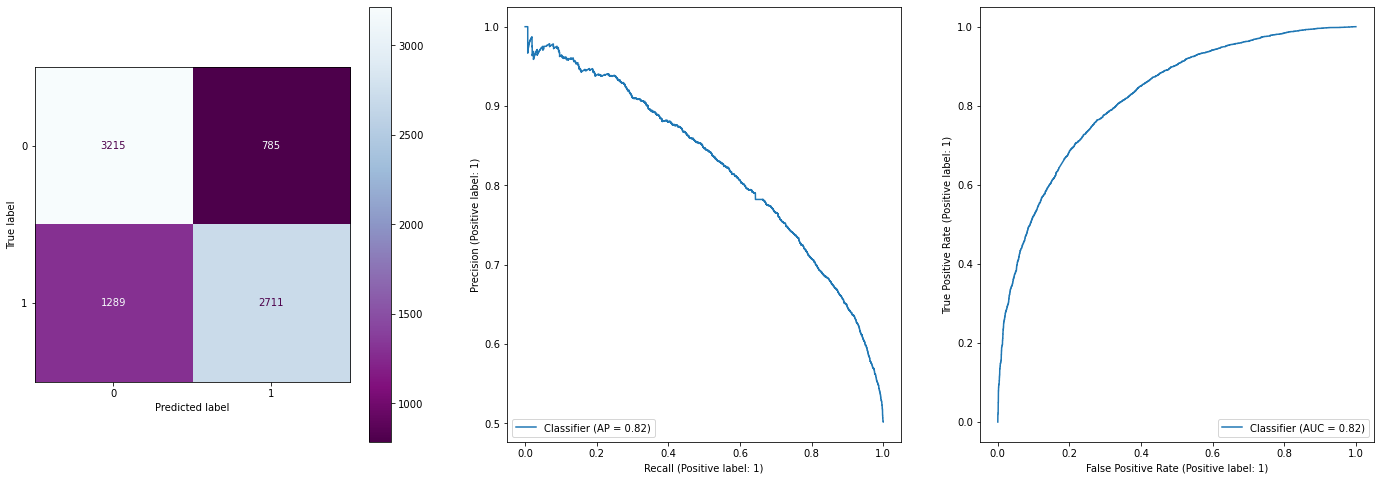

In [43]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, x_test_lemma, y_test_lemma, y_test_pred, y_test_pred_proba)

## Modèle BERT

In [44]:
X_cleaned= pd.Series(" ".join([token.text.lower() for token in doc if token.is_alpha and token.text.lower() not in all_stopwords]) for doc in nlp.pipe(X))

In [45]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [46]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [47]:
max_len = 0

for tweet in X_cleaned:
    max_len = max(max_len, len(tweet))

print('Max tweet length: ', max_len)

Max tweet length:  136


In [48]:
def mask_inputs_for_bert(tweets, max_len):
    input_ids = []
    attention_masks = []

    for tweet in tweets:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens = True,
            max_length = max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask = True
        )
    
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    
    return input_ids, attention_masks

In [49]:
train_inp, train_mask = mask_inputs_for_bert(X_train, max_len)
test_inp, test_mask = mask_inputs_for_bert(X_test, max_len)
train_label = tf.convert_to_tensor(y_train)
test_label = tf.convert_to_tensor(y_test)

In [50]:
print("Train_input shape", train_inp.shape)
print("Train_mask shape", train_mask.shape)
print("Test_input shape", test_inp.shape)
print("Test_mask shape", test_mask.shape)
print("Train_label shape", train_label.shape)
print("Test_label shape", test_label.shape)

Train_input shape (32000, 136)
Train_mask shape (32000, 136)
Test_input shape (8000, 136)
Test_mask shape (8000, 136)
Train_label shape (32000,)
Test_label shape (8000,)


In [54]:
model_name = "bert"

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    bert_model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()

    bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

    bert_model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=[metric])

    bert_model.fit(
            [train_inp, train_mask],
            train_label,
            epochs=10,
            batch_size=256,
            validation_data=([test_inp, test_mask], test_label),
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )
    
    # Save the model
    bert_model.save(model_path)

    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
 79/125 [=================>............] - ETA: 5:32:07 - loss: 0.5809 - accuracy: 0.6914

KeyboardInterrupt: 

In [ ]:
start_pred = time.time()

y_test_pred_proba = bert_model([test_inp, test_mask])

prediction_logits = y_test_pred_proba[0]

prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()

prediction_probs_bis = []

for element in prediction_probs:
    prediction_probs_bis.append(element[1])

y_test_pred = [round(pred_proba) for pred_proba in prediction_probs_bis]

end_pred = time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, prediction_probs_bis, training_time, predict_time)


Resultats modèle : bert


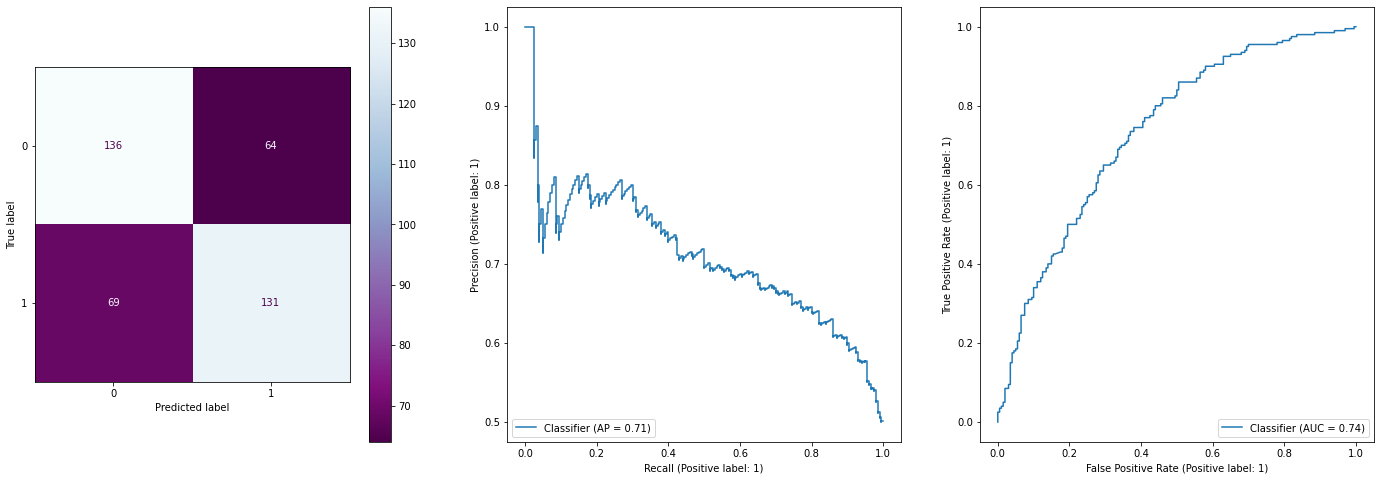

In [ ]:
print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(bert_model, [test_inp, test_mask], y_test, y_test_pred, prediction_probs_bis)

## Synthèse comparative

In [ ]:
with open('models/train_times.json', 'w') as f:
    json.dump(train_times, f)

In [ ]:
pd.DataFrame.from_dict(synthese, orient='index')

,f1 score,accuracy,recall,AUC,Training time,Predict time
bert,0.663291,0.6675,0.655,0.736237,3458.197571,74.592396
